**Часть 1**

Форма массива: (131, 175, 3)


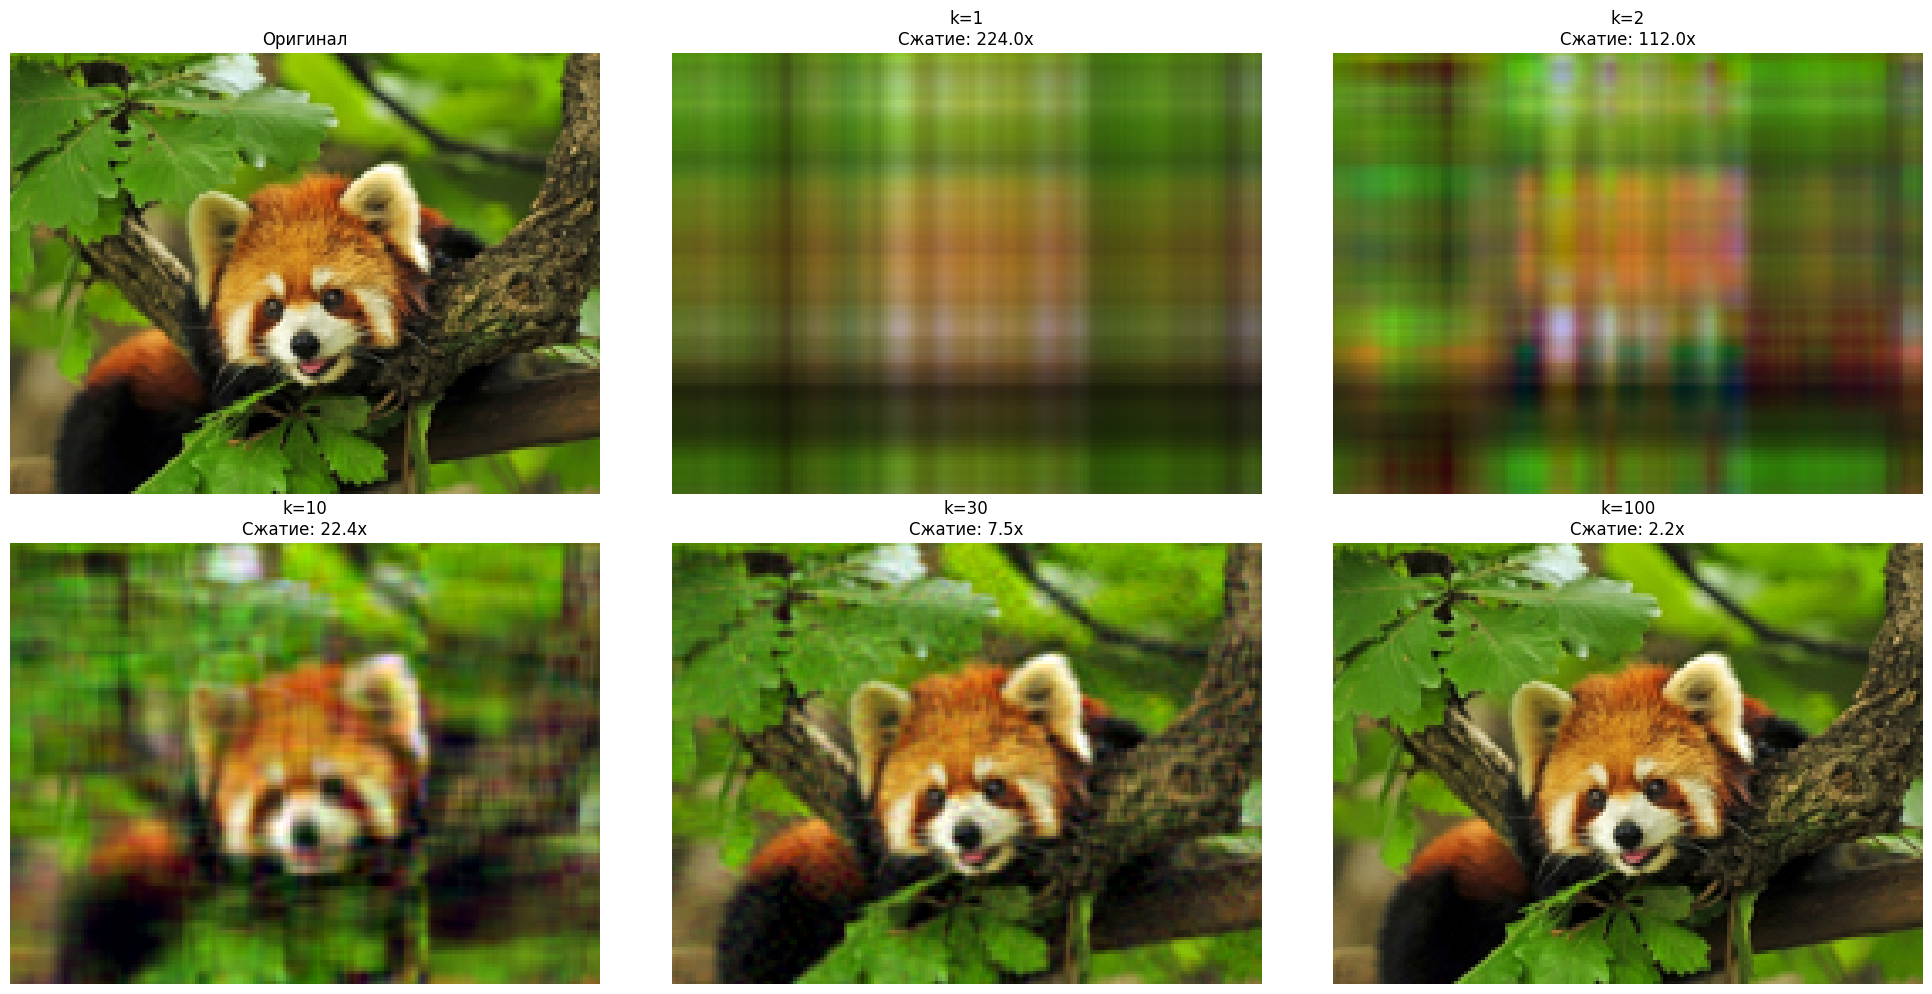

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os

img = Image.open('panda.jpg')
w, h = img.size
img = img.resize((w//4, h//4))
w, h = img.size

x = np.array(img, dtype=np.float32)
print(f"Форма массива: {x.shape}")

def compress_channel(channel, k):
    U, S, V = np.linalg.svd(channel, full_matrices=False)
    compressed = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    return np.clip(compressed, 0, 255).astype(np.uint8)

def compress_rgb_image(image_array, k):
    if len(image_array.shape) == 3:
        compressed_channels = []
        for i in range(3):
            compressed_channel = compress_channel(image_array[:, :, i], k)
            compressed_channels.append(compressed_channel)
        return np.stack(compressed_channels, axis=2)
    else:
        return compress_channel(image_array, k)

def calculate_size(U, S, V, k):
    m, n = U.shape[0], V.shape[1]
    size_compressed = (m * k + k + n * k) * 4
    size_original = m * n * 3 * 4
    return size_compressed, size_original

k_values = [1, 2, 10, 30, 100]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

axes[0].imshow(x.astype(np.uint8))
axes[0].set_title('Оригинал')
axes[0].axis('off')

for i, k in enumerate(k_values, 1):
    if i >= len(axes):
        break

    compressed_img = compress_rgb_image(x, k)

    U, S, V = np.linalg.svd(x[:, :, 0], full_matrices=False)
    size_compressed, size_original = calculate_size(U, S, V, k)
    compression_ratio = size_original / size_compressed

    axes[i].imshow(compressed_img)
    axes[i].set_title(f'k={k}\nСжатие: {compression_ratio:.1f}x')
    axes[i].axis('off')

    Image.fromarray(compressed_img).save(f'compressed_k_{k}.jpg')

plt.tight_layout()
plt.show()

**Часть 2**


Многомерное Гауссово распределение

Матрица ковариации для повернутых точек:
[[ 0.13399223 -0.12043313]
 [-0.12043313  0.1277392 ]]

Матрица ковариации для multivariate_normal:
[[ 0.16111068 -0.15182254]
 [-0.15182254  0.16045202]]


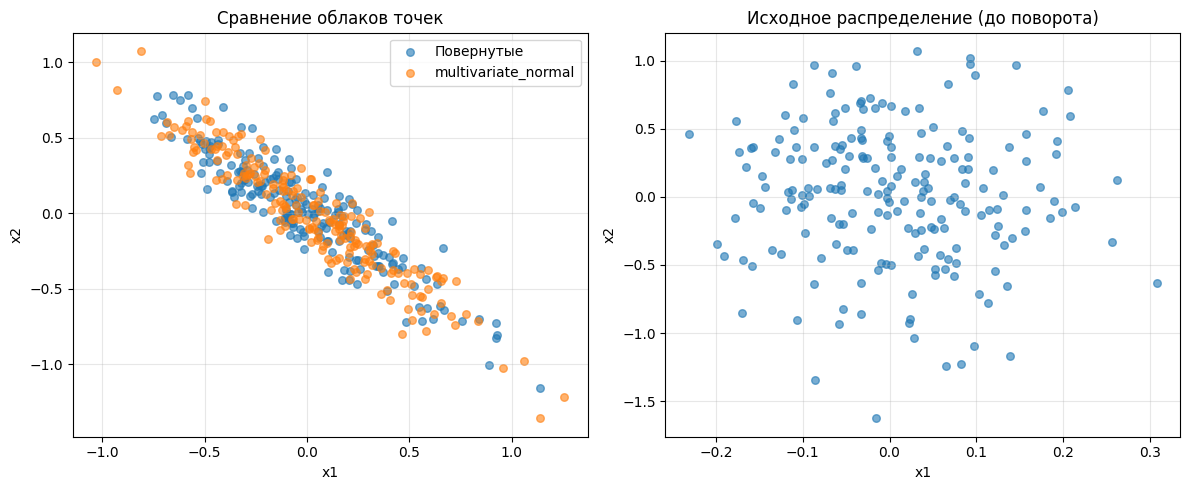

In [6]:
import numpy as np
import matplotlib.pyplot as plt

M = 200
sigma1 = 0.1
sigma2 = 0.5
alpha = np.pi / 4  # угол поворота 45 градусов

x1 = np.random.randn(M, 1) * sigma1
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1)

R = np.array([[np.cos(alpha), -np.sin(alpha)],
              [np.sin(alpha), np.cos(alpha)]])

X_rotated = X @ R.T

cov_matrix = R @ np.diag([sigma1**2, sigma2**2]) @ R.T
X_multivariate = np.random.multivariate_normal([0, 0], cov_matrix, M)

cov_rotated = np.cov(X_rotated.T)
cov_multivariate = np.cov(X_multivariate.T)

print("Матрица ковариации для повернутых точек:")
print(cov_rotated)
print("\nМатрица ковариации для multivariate_normal:")
print(cov_multivariate)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6, s=30, label='Повернутые')
plt.scatter(X_multivariate[:, 0], X_multivariate[:, 1], alpha=0.6, s=30, label='multivariate_normal')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Сравнение облаков точек')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=30)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Исходное распределение (до поворота)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Плотность вероятности гауссового распределения

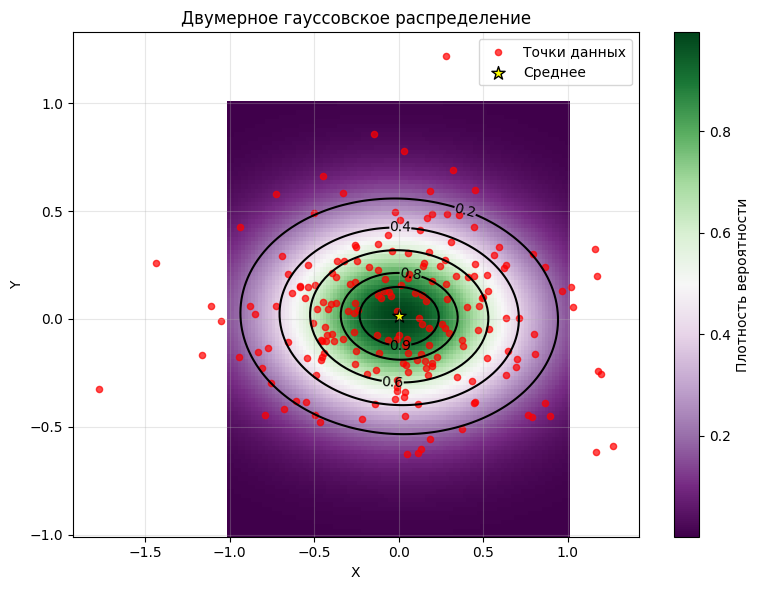

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)
points = np.random.multivariate_normal(mean=[0, 0], cov=[[0.3, 0], [0, 0.1]], size=200)

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100)
XX, YY = np.meshgrid(xx, yy)
pp = np.stack((XX.flatten(), YY.flatten()), axis=1)

mu = np.mean(points, axis=0)
C = np.cov(points, rowvar=False)
m = multivariate_normal(mean=mu, cov=C)

ZZ = m.pdf(pp).reshape(XX.shape)

plt.figure(figsize=(8, 6))
IMG = plt.pcolor(XX, YY, ZZ, cmap='PRGn', shading='auto')
plt.colorbar(IMG, label='Плотность вероятности')

CS = plt.contour(XX, YY, ZZ, levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(points[:, 0], points[:, 1], c='red', s=20, alpha=0.7, label='Точки данных')
plt.scatter(mu[0], mu[1], c='yellow', s=100, marker='*', edgecolors='black', label='Среднее')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Двумерное гауссовское распределение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Бинарная классификация

Результаты:
Класс 0: 500 точек, μ=[-2.50073689  9.07998368], p=0.500
Класс 1: 500 точек, μ=[4.75371468 2.12805175], p=0.500

Ковариация C₀:
[[ 3.75098845 -0.0985255 ]
 [-0.0985255   3.92805373]]

Ковариация C₁:
[[3.65299098 0.11103904]
 [0.11103904 4.30118942]]


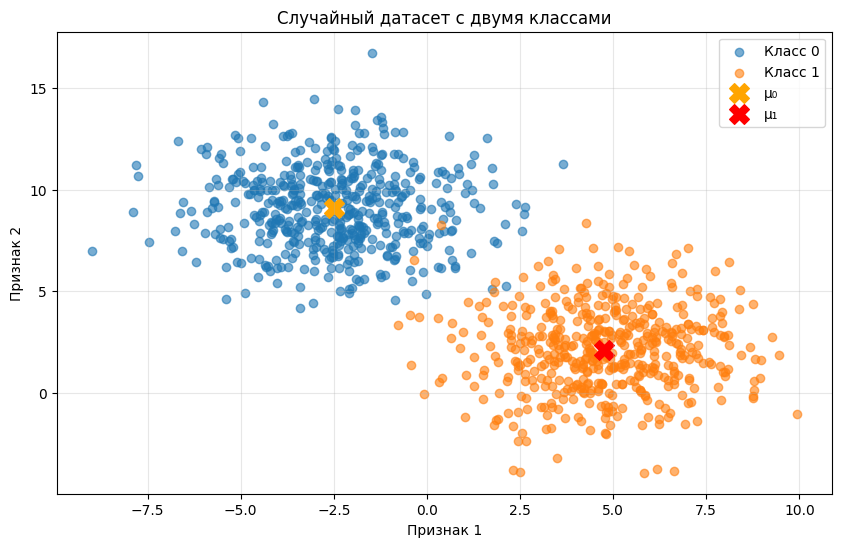

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(42)
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=2.0)

X0, X1 = X[y == 0], X[y == 1]
mu0, mu1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
C0, C1 = np.cov(X0, rowvar=False), np.cov(X1, rowvar=False)
p0, p1 = len(X0)/len(X), len(X1)/len(X)

print("Результаты:")
print(f"Класс 0: {len(X0)} точек, μ={mu0}, p={p0:.3f}")
print(f"Класс 1: {len(X1)} точек, μ={mu1}, p={p1:.3f}")
print(f"\nКовариация C₀:\n{C0}\n\nКовариация C₁:\n{C1}")

plt.figure(figsize=(10, 6))
plt.scatter(X0[:, 0], X0[:, 1], alpha=0.6, label='Класс 0')
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.6, label='Класс 1')
plt.scatter(mu0[0], mu0[1], s=200, marker='X', c='orange', label='μ₀')
plt.scatter(mu1[0], mu1[1], s=200, marker='X', c='red', label='μ₁')
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Случайный датасет с двумя классами')
plt.legend(), plt.grid(True, alpha=0.3)
plt.show()


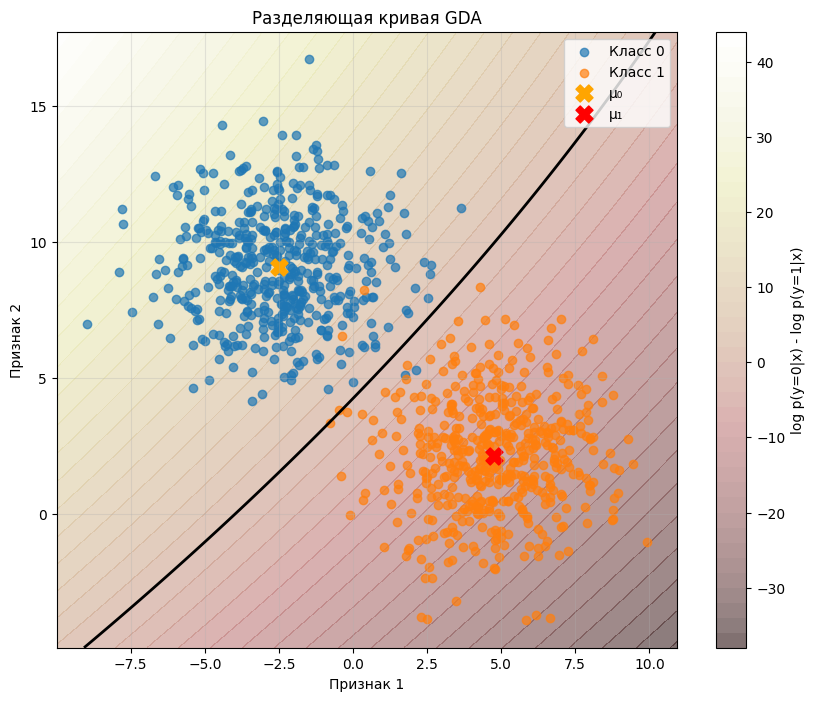

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=2.0, random_state=42)
X0, X1 = X[y == 0], X[y == 1]
mu0, mu1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
C0, C1 = np.cov(X0, rowvar=False), np.cov(X1, rowvar=False)
p0, p1 = len(X0)/len(X), len(X1)/len(X)

x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))


def decision_function(x):# Функция решения
    diff = np.zeros(x.shape[0])
    for i, point in enumerate(x):
        log_p0 = -0.5*np.log(np.linalg.det(C0)) - 0.5*(point-mu0).T@np.linalg.inv(C0)@(point-mu0) + np.log(p0)
        log_p1 = -0.5*np.log(np.linalg.det(C1)) - 0.5*(point-mu1).T@np.linalg.inv(C1)@(point-mu1) + np.log(p1)
        diff[i] = log_p0 - log_p1
    return diff

Z = decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.6, cmap='pink', levels=50)
plt.colorbar(label='log p(y=0|x) - log p(y=1|x)')
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
plt.scatter(X0[:, 0], X0[:, 1], alpha=0.7, label='Класс 0')
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.7, label='Класс 1')
plt.scatter(mu0[0], mu0[1], s=150, marker='X', c='orange', label='μ₀')
plt.scatter(mu1[0], mu1[1], s=150, marker='X', c='red', label='μ₁')
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Разделяющая кривая GDA')
plt.legend(), plt.grid(alpha=0.3)
plt.show()